<h1><center><strong><font color="chillipepper">Task Specific Modeling: Sequence Classification with and without Context</font></strong></center></h1>
<h3><center><font color="green"><strong>Correction 💯</strong></font></center></h3>

------------------------

# Google Colab Tips
- CTRL + / => comment or uncomment current selection
- CTRL + ENTER -> run current cell
- SHIFT + ENTER -> run current cell and go to next one (or create a next empty one if none exists)
- ESCAPE -> when in a cell, goes to the outside of the cell, enabling ARROWS navigation
- ENTER -> when navigating between cells using ARROWS, press ENTER to start editing the cell
- don't forget you can fold and unfold sections (i.e. markdown sections)

------------------------

In this lab you will use two different datasets for two tasks (sequence classification and sequence classification in conversation). You will learn the basics of PyTorch and how to deal with two different tasks, requiring specific models, data preparation, and so on. These tasks are multi-class only, which means the model will predict a class among more than 2 possible classes.

Hence, you also will train your first PyTorch models and evaluate them. 

Please use this lab a reference for PyTorch good practices and pay attention to the comments in the models, these comments contain important details about the important lines of code.

# Outline

- PyTorch Basics
  - Pre-trained Embeddings Imports
  - PyTorch Data Handling
  - PyTorch Basic Model
- Classification Task
  - Dataset and Task Presentation: 😍, 😂, 💕
  - Create your Own Basic Model
  - Create the Training Loop as a Function 📉
  - Create the Inference Function with Plots
  - Evaluate on the test set 📊
  - An alternative with a BERT model's finetuning
- Dialog Act Classification in Conversation Task
  - Dataset and Taks Presentation: `__dummy__`, `inform`, `question`, `directive`, `commissive`
  - Adapt the Data Handling
  - Adapt the Model and the loops (training 📉, inference)
- Conclusion

In [1]:
! pip install datasets
! pip install transformers
! pip install torchinfo

In [2]:
import torch
from datasets import load_dataset
from tqdm import tqdm
import nltk
from gensim.models.phrases import Phrases, Phraser
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
import pandas as pd
from termcolor import colored
from collections import Counter

# <font color="chillipepper">**Deep Learning in PyTorch image.png**</font>

## <font color="chillipepper">Pytorch</font>
PyTorch is a Python based library for scientific computing that provides three main features:
- An n-dimensional Tensor, which is similar to numpy but can run on GPUs
- Easily build big computational graphs for deep learning
- Automatic differentiation for computing gradients 

Usages : 
- It’s a Python-based scientific computing package targeted at two sets of audiences:
    - A replacement for NumPy to use the power of GPUs
    - a deep learning research platform that provides maximum flexibility and speed


___
<h1><center><font color="chillipepper">Pytorch basics</font></center></h1>

**NB** : Tensor are the basics block of pytorch. Tensor allows to store data (input data or target data) as well as the parameters (also called weights, neurons,...) of your neural network.


- tensor creation 
- tensor types 
- basic operations between tensors
- from and to numpy 
- about GPU 

In [3]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

### <font color="chillipepper">Tensors</font>
(image by [Matthew Mayo](https://www.kdnuggets.com/author/matt-mayo))

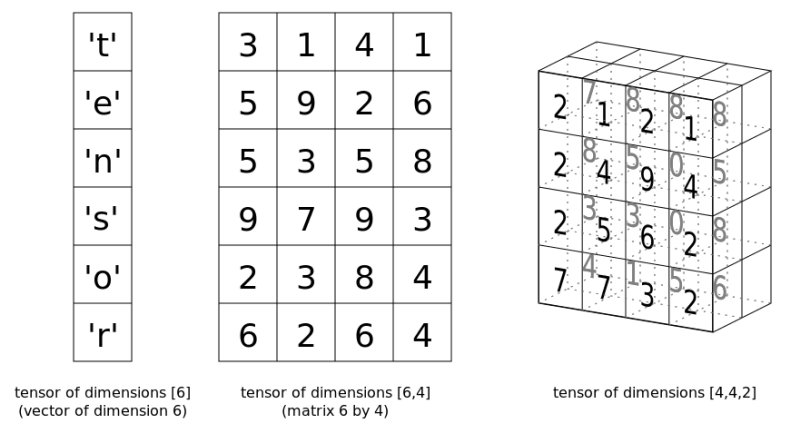

**What is a pytorch tensor ?** : A torch.Tensor is a multi-dimensional matrix containing elements of a single data type.

Tensors are similar to NumPy’s ndarrays, with the addition being that Tensors can also be used on a GPU to accelerate computing.

**How to define a pytorch tensor ?**
- using existing constructors : _torch.ones_ , _torch.zeros_ _torch.rand_
- based on existing object
    - from another tensor (or only using the shape of the other tensor)
    - from a python list 
    - from a numpy array

In [4]:
# define 
ones = torch.ones(3,2)
# a tensor can be printed
print(ones)

tensor([[1., 1.],
        [1., 1.],
        [1., 1.]])


In [5]:
# other basic definition 
print(torch.zeros(5,3), "\n", 
      torch.rand(2,3), "\n", 
      torch.empty(2,2))

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]) 
 tensor([[0.3889, 0.1566, 0.0897],
        [0.4595, 0.3528, 0.7420]]) 
 tensor([[0., 0.],
        [0., 0.]])


In [6]:
# from a python list 
ls = [[[1,3,5,6],[-1,4,4,4]],[[-1,-3,-5,-6],[10,-4,-4,-4]]]
tensor = torch.Tensor(ls)
print(tensor)
# from a numpy array : 
array = np.array([0,1])
#array
tensor = torch.from_numpy(array)
print(tensor)
# symetrically  tensor.numpy()

tensor([[[ 1.,  3.,  5.,  6.],
         [-1.,  4.,  4.,  4.]],

        [[-1., -3., -5., -6.],
         [10., -4., -4., -4.]]])
tensor([0, 1])


If the list is not a proprer matrix shape, an exception is returned!

Uncomment the following cell to view the **error prompt**

In [7]:
# # list must be in a proper matrix shape
# ls = [[[1,3,5,6],[-1,4,4,4]],[[-1,-3,-5,-6],[10,-4,-4]]]
# torch.Tensor(ls)

**Basic manipulations**
- access type / change data types 
- access elements 
- reshape 
- maths opertions : add, multiply , ..
- differentiate / derive
- set to a specific _device_ : GPU , GPU:0, GPU:1 , CPU ...

In [8]:
# get type 
print(tensor,tensor.dtype)
# change type 
tensor = tensor.float()

tensor([0, 1]) torch.int64


**NB** : types are important in Deep Learning  because : 
- some types are more memory consumming than others : e.g : float16 vs float32
- some operations require specific type (cf. Embedding layer ...)

In [9]:
tensor = torch.rand(5,2,2)
print(tensor)
# access one element
print(tensor[0,1,1])
# access several element
print(tensor[:3,0,:2])

tensor([[[0.0485, 0.8516],
         [0.7956, 0.6164]],

        [[0.2724, 0.8428],
         [0.8168, 0.1327]],

        [[0.6916, 0.7049],
         [0.7127, 0.8553]],

        [[0.8133, 0.4483],
         [0.0903, 0.9595]],

        [[0.2486, 0.6262],
         [0.5397, 0.0363]]])
tensor(0.6164)
tensor([[0.0485, 0.8516],
        [0.2724, 0.8428],
        [0.6916, 0.7049]])


**NB** : pytorch tensor indexing exactly match numpy indexing

In [10]:
# get the shape of a tensor
tensor.size()
# reshape it 
print(tensor, "\n",
      tensor.view(2,2,5))

tensor([[[0.0485, 0.8516],
         [0.7956, 0.6164]],

        [[0.2724, 0.8428],
         [0.8168, 0.1327]],

        [[0.6916, 0.7049],
         [0.7127, 0.8553]],

        [[0.8133, 0.4483],
         [0.0903, 0.9595]],

        [[0.2486, 0.6262],
         [0.5397, 0.0363]]]) 
 tensor([[[0.0485, 0.8516, 0.7956, 0.6164, 0.2724],
         [0.8428, 0.8168, 0.1327, 0.6916, 0.7049]],

        [[0.7127, 0.8553, 0.8133, 0.4483, 0.0903],
         [0.9595, 0.2486, 0.6262, 0.5397, 0.0363]]])


In [11]:
intTensor = torch.ones(3,2, dtype=torch.float32)
print(intTensor, intTensor.dtype)
intTensor.int()

tensor([[1., 1.],
        [1., 1.],
        [1., 1.]]) torch.float32


tensor([[1, 1],
        [1, 1],
        [1, 1]], dtype=torch.int32)

### <font color="chillipepper">All operations on tensors</font> 
- all reshape 
- squeeze 
- sum , prod 
- max, norm ...

❗**Beware of Broadcasting** ❗ issues if your tensors does not have the same size. As in [Numpy broadcasting](https://numpy.org/devdocs/user/basics.broadcasting.html#general-broadcasting-rules), some operations above can broadcast, i.e. extend, their application to the size of the targeted tensor.

One really good explanation about PyTorch specific broadcasting can be found here: https://stackoverflow.com/questions/51371070/how-does-pytorch-broadcasting-work

Let's take the same example and reproduce it here.



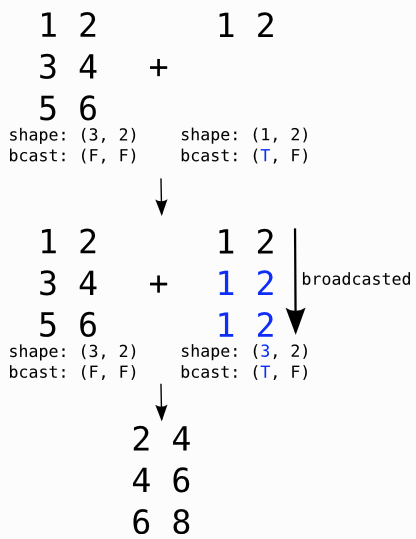

In PyTorch we reproduce it as follows:

In [12]:
tensor_a = torch.Tensor([[1,2], [3,4], [5,6]])
tensor_b = torch.Tensor([1,2])
tensor_a + tensor_b

tensor([[2., 4.],
        [4., 6.],
        [6., 8.]])

## <font color="chillipepper">Automatic Differentiation</font>

The core component of any modern deep learning library is _Automatic Differentiation_. 


**Recall**
- Training any deep learning model requires backpropagatation 
- Backpropagation is an algorithm that efficiently computes the gradient of a neural network's output based on its input and with regard to all its parameters (or also named weights)

_Automatic Differentiation_ provides a way of automatically computing gradients of any function. In other words, _automatic differentiation_ gives you the possibility to build complex neural network without caring about computing the gradients by yourself. 


**NB** 

Having access to an open source library that performs Automatic Differentation (tensorflow/pytorch and before Dynet or Theano..) is one of the reasons for the popularity and sucess of Deep Learning today.

### <font color="chillipepper">Automatic Differentiation in a nutshell</font>


**Definition**
Automatic differentiation refers to a general way of taking a program which computes a value, and automatically constructing a procedure for computing derivatives of that value.

Automatic Differentation requires 3 steps 

1. Building a computation Graph 
2. propagating inputs throughout the graph (forward pass)
3. Computing gradient of each of the node in the graph (backward pass)

In [13]:
x = torch.ones(2, 2, requires_grad=True)
# double checking if gradient 
print("Checking gradient is set to {}. Its gradient is still {} ".format(x.requires_grad, x.grad))

Checking gradient is set to True. Its gradient is still None 


In [14]:
# let us define a basic operation
y = x+1
print(y)

tensor([[2., 2.],
        [2., 2.]], grad_fn=<AddBackward0>)


Do not fret due to the warning. It means that you are accessing the `.grad` field of a Tensor for which pytorch will never populate the `.grad` field.
This will not be the case later on.


In [15]:
# y has now a gradient attribute , grad is none
y.grad_fn, y.grad

/var/folders/m3/h_276b0j01x2tp0btl5lw2s40000gr/T/ipykernel_77767/1874857746.py:2: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  y.grad_fn, y.grad


(<AddBackward0 at 0x2c4d30b50>, None)

In [16]:
z = y * y * 3
out = z.mean()
print('z = ', z)
print('out = ', out)
print('z and y grad = ', z.grad, y.grad)

z =  tensor([[12., 12.],
        [12., 12.]], grad_fn=<MulBackward0>)
out =  tensor(12., grad_fn=<MeanBackward0>)
z and y grad =  None None


/var/folders/m3/h_276b0j01x2tp0btl5lw2s40000gr/T/ipykernel_77767/2403453142.py:5: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print('z and y grad = ', z.grad, y.grad)


In [17]:
out.backward() # backpropagation
# Let's inspect the gradient at each previous variable' gradients now
print("Gradients with regard to intermediate nodes:", out.grad, z.grad, y.grad)
print("Gradients with regard to the input node that we considered to be the parameter:", x.grad)

Gradients with regard to intermediate nodes: None None None
Gradients with regard to the input node that we considered to be the parameter: tensor([[3., 3.],
        [3., 3.]])


/var/folders/m3/h_276b0j01x2tp0btl5lw2s40000gr/T/ipykernel_77767/3927720886.py:3: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print("Gradients with regard to intermediate nodes:", out.grad, z.grad, y.grad)


In [18]:
# to manipulate a tensor without its gradient 
out.detach()

tensor(12.)

In [19]:
x = torch.ones(2, 2, requires_grad=True)
print('x', x)
y = x+1
print('y', y)
# y.grad_fn, y.grad
z = y * y * 3
print('z', z)
out = z.mean()
print('out', out)
print('x grad', x.grad)
out.backward()
print('x grad', x.grad, x.grad.data, x.grad_fn)
print('y grad', y.grad, y.grad_fn)
print('z grad', z.grad, z.grad_fn)
print('out grad', out.grad, out.grad_fn)



x tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
y tensor([[2., 2.],
        [2., 2.]], grad_fn=<AddBackward0>)
z tensor([[12., 12.],
        [12., 12.]], grad_fn=<MulBackward0>)
out tensor(12., grad_fn=<MeanBackward0>)
x grad None
x grad tensor([[3., 3.],
        [3., 3.]]) tensor([[3., 3.],
        [3., 3.]]) None
y grad None <AddBackward0 object at 0x2c4d33ac0>
z grad None <MulBackward0 object at 0x2c4d31f30>
out grad None <MeanBackward0 object at 0x2c4d32cb0>


/var/folders/m3/h_276b0j01x2tp0btl5lw2s40000gr/T/ipykernel_77767/4277353485.py:13: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print('y grad', y.grad, y.grad_fn)
/var/folders/m3/h_276b0j01x2tp0btl5lw2s40000gr/T/ipykernel_77767/4277353485.py:14: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on t

In [20]:
import torch

# Creating the graph
x = torch.tensor(1.0, requires_grad = True)
y = torch.tensor(2.0)
z = x * y

# Displaying
for i, name in zip([x, y, z], "xyz"):
    print(f"{name}\ndata: {i.data}\nrequires_grad: {i.requires_grad}\n\
    grad: {i.grad}\ngrad_fn: {i.grad_fn}\nis_leaf: {i.is_leaf}\n")

x
data: 1.0
requires_grad: True
    grad: None
grad_fn: None
is_leaf: True

y
data: 2.0
requires_grad: False
    grad: None
grad_fn: None
is_leaf: True

z
data: 2.0
requires_grad: True
    grad: None
grad_fn: <MulBackward0 object at 0x2c4d331c0>
is_leaf: False



/var/folders/m3/h_276b0j01x2tp0btl5lw2s40000gr/T/ipykernel_77767/3306691725.py:11: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  grad: {i.grad}\ngrad_fn: {i.grad_fn}\nis_leaf: {i.is_leaf}\n")


In [21]:
import torch
# Creating the graph
x = torch.tensor(1.0, requires_grad = True)
z = x ** 3
z.backward() #Computes the gradient 
print(x.grad.data) #Prints '3' which is dz/dx 

tensor(3.)


# <font color="chillipepper">**Sequence Classification** 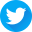 -> 😍, 😂, 💕</font>

Our task is to predict an emoji for a given text. The text here will be a tweet, and the emoji will be a given indice.

This is a **multiclass classification task** because we have more than 2 classes by opposition with binary classifications.

First let's import pre-trained embeddings

## <font color="chillipepper">Import Pre-trained Embeddings</font> 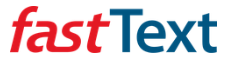

In [22]:
! pip install torchtext

In [23]:
# fasttext vectors can be imported through torch text (it will download it only once)
from torchtext.vocab import GloVe, vocab, FastText

# pretrained_vectors = GloVe(name="6B", dim='50')
pretrained_vectors = FastText(language='en')

Let's look at the vectors

In [24]:
#! pip install torchtext
#pretrained_vectors.vectors

And look at the matrix size (each vector has a 300 dimension)

In [25]:
pretrained_vectors.vectors.size()

torch.Size([2519370, 300])

Let's see what the model looks like

In [26]:
for i, (key, value) in enumerate(pretrained_vectors.stoi.items()):
  print(colored('token:', 'cyan'), key, colored('| indice:','cyan'), value)
  # we only look at the first 5 elements
  if i > 5: break

token: , | indice: 0
token: . | indice: 1
token: the | indice: 2
token: </s> | indice: 3
token: of | indice: 4
token: - | indice: 5
token: in | indice: 6


Words and associated indices. Seems like what we need to numericalize the text data!

Below you will find examples of handling the Vocab object from TorchText and exploring your data. 

With `pretrained_vocab.insert_token("<unk>",unk_index)` we add the unknown token in the vocabulary. We do the same for the padding token.

In [27]:
from torchtext.vocab import GloVe, FastText, vocab

pretrained_vocab = vocab(pretrained_vectors.stoi)
unk_token = "<unk>"
unk_index = 0
pad_token = '<pad>'
pad_index = 1
pretrained_vocab.insert_token("<unk>",unk_index)
pretrained_vocab.insert_token("<pad>", pad_index)
#this is necessary otherwise it will throw runtime error if OOV token is queried 
pretrained_vocab.set_default_index(unk_index)
pretrained_embeddings = pretrained_vectors.vectors
pretrained_embeddings = torch.cat((torch.zeros(1,pretrained_embeddings.shape[1]),pretrained_embeddings))
pretrained_embeddings.size()

torch.Size([2519371, 300])

In [28]:
pretrained_vocab.get_stoi()['<pad>']

1

## <font color="chillipepper">Pytorch Data Handling</font>

We will first use the `tweet_eval` corpus. To be precise we will only use a subset dedicated to emojis, and will only consider 3 emojis. 

The dataset is made of:

| name            | train | validation | test  |
| --------------- | ----- | ---------- | ----- |
| emoji           | 45000 | 5000       | 50000 |

For `emoji` config:

- `text`: a `string` feature containing the tweet.

- `label`: an `int` classification label with the following mapping:

    `0`: ❤ ,  `1`: 😍, `2`: 😂, `3`: 💕, `4`: 🔥, `5`: 😊, `6`: 😎,  `7`: ✨,    `8`: 💙,     `9`: 😘,  `10`: 📷, `11`: 🇺🇸, `12`: ☀, `13`: 💜, `14`: 😉,  `15`: 💯, `16`: 😁, `17`: 🎄, `18`: 📸, `19`: 😜

Hence, a row is represented as:
```
{'label': 12, 'text': 'Sunday afternoon walking through Venice in the sun with @user ️ ️ ️ @ Abbot Kinney, Venice'}
```
Which means the text is associated to the emoji ☀

Links: 
- https://huggingface.co/datasets/tweet_eval

In [29]:
# we import the data using hugging face datasets, we specify the 'emoji' subset
tweet_eval = load_dataset('tweet_eval', 'emoji')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/45000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Let's look at the data object

In [30]:
tweet_eval

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 45000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 5000
    })
})

There are 3 splits: 'train', 'validation', and 'test'. 

Let's look at the label distribution in the trainset

In [31]:
# keep in mind we represent emojis as indices
print(Counter(tweet_eval['train']['label']) )

Counter({0: 9204, 1: 4901, 2: 4713, 7: 2345, 4: 2146, 5: 2132, 6: 2078, 3: 2043, 10: 1982, 18: 1510, 17: 1397, 9: 1391, 16: 1350, 8: 1287, 12: 1246, 14: 1224, 19: 1191, 13: 980, 11: 946, 15: 934})


The data is so unbalanced that we will only consider the following emojis for this lab: `1`: 😍, `2`: 😂, `3`: 💕

In [32]:
def adjust_labels(entries):
  res = {}
  res['text'] = entries['text']
  res['label'] = [ label - 1 for label in entries['label']]
  return res

for split in ['train', 'validation', 'test']:
  rows_to_select = [ i for i, entry in enumerate(tweet_eval[split]) if entry['label'] <= 3 and entry['label'] != 0 ]
  tweet_eval[split] = tweet_eval[split].select(rows_to_select)
  tweet_eval[split] = tweet_eval[split].map(lambda e: adjust_labels(e)  , batched=True)

Map:   0%|          | 0/11657 [00:00<?, ? examples/s]

Map:   0%|          | 0/1333 [00:00<?, ? examples/s]

Map:   0%|          | 0/11969 [00:00<?, ? examples/s]

Let's look at the distribution again, and the number of rows

In [33]:
print(Counter(tweet_eval['train']['label']) )

Counter({0: 4901, 1: 4713, 2: 2043})


In [34]:
tweet_eval

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 11657
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 11969
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1333
    })
})

In [35]:
tweet_eval['train'][0]

{'text': 'Man these are the funniest kids ever!! That face! #HappyBirthdayBubb @ FLIPnOUT Xtreme',
 'label': 1}

In [36]:
tweet_eval['train']['text'][:3]

['Man these are the funniest kids ever!! That face! #HappyBirthdayBubb @ FLIPnOUT Xtreme',
 "I L VE working for a cause! Yesterday's balloon decor for SNN 11th Annual Back 2 School Health…",
 "Dem shoes tho! Lol! ...I'm getting some! Get ready copleypriceymca…"]

In [37]:
tweet_eval['train']['label'][:3]

[1, 0, 1]

### <font color="chillipepper">Tokenize, numericalize, and trim and pad the data</font>

Once again we will use the Tweet Tokenizer.
In this lab we want to focus on the machine learning part, so you don't need to code the data preparation we tackled in the previous lab.

In [38]:
from nltk.tokenize import TweetTokenizer
from tqdm.notebook import tqdm

tok = TweetTokenizer()
tok.tokenize("I have a new GPU!".lower())

['i', 'have', 'a', 'new', 'gpu', '!']

We will consider the following functions:

In [39]:
def tokenize_pad_numericalize(entry, vocab_stoi, max_length=20):
  text = [ vocab_stoi[token] if token in vocab_stoi else vocab_stoi['<unk>'] for token in tok.tokenize(entry.lower())]
  padded_text = None
  if len(text) < max_length:   padded_text = text + [ vocab_stoi['<pad>'] for i in range(len(text), max_length) ] 
  elif len(text) > max_length: padded_text = text[:max_length]
  else:                        padded_text = text
  return padded_text

def tokenize_all(entries, vocab_stoi):
  res = {}
  res['text'] = [tokenize_pad_numericalize(entry, vocab_stoi, max_length=200) for entry in entries['text']]
  res['label'] = entries['label']
  return res

tweet_eval['train'] = tweet_eval['train'].map(lambda e: tokenize_all(e, pretrained_vocab.get_stoi()), batched=True)

Map:   0%|          | 0/11657 [00:00<?, ? examples/s]

In [40]:
print(tweet_eval['train']['text'][:2])

[[403, 123, 35, 3, 32344, 3725, 827, 181, 181, 21, 1393, 181, 0, 4074, 0, 28145, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [29, 369, 495, 664, 18, 13, 1405, 181, 0, 9583, 33595, 18, 232126, 0, 1278, 254, 0, 96, 732, 7532, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

We apply it to validation and test set

In [41]:
tweet_eval['validation'] = tweet_eval['validation'].map(lambda e: tokenize_all(e, pretrained_vocab.get_stoi()), batched=True)
tweet_eval['test'] = tweet_eval['test'].map(lambda e: tokenize_all(e, pretrained_vocab.get_stoi()), batched=True)

Map:   0%|          | 0/1333 [00:00<?, ? examples/s]

Map:   0%|          | 0/11969 [00:00<?, ? examples/s]

#### 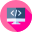 **TODO! Complete the Dataset class**

**Complete the class below** in order to create a dataset. Each returned element by `__getitem__` should be in the form of `dict_keys(['text', 'label'])`

You may need: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [42]:
from torch.utils.data import Dataset
import numpy as np

class TweetDataset(Dataset):
    def __init__(self, data, args):
      # args is a dict, a nice way to share the global arguments (even accross multiple files)
      self.args = args
      self.data = data

    def __len__(self):
      return len(self.data)
    
    def __getitem__(self, idx):
      item = {
          "text": np.array(self.data[idx]['text']),
          "label": np.array(self.data[idx]['label'])
      }
      # warning: if you put   self.data['text'][idx]    it will take A LOT of time...
      ## The following code would take forever just to print next(iter(train_loader))['text'].shape
      # item = {
      #     "text": np.array(self.data['text'][idx]),
      #     "label": np.array(self.data['label'][idx])
      # }
      return item

#### 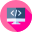 **TODO! create the DataLoaders**

Now **create the DataLoaders** (one per split) using you custom Dataset class.

Don't forget to handle the last batch (which can have a different size).
DataLoaders should shuffle the data for each batch.
The batch size should be used from the `args` variable (so it would be modifiable afterwards)

You may need: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [45]:
# Create DataLoader
from torch.utils.data import DataLoader
args = {'bsize': 64}
train_loader = DataLoader(TweetDataset(tweet_eval['train'], args), batch_size=args['bsize'], num_workers=0, shuffle=True, drop_last=True)
val_loader   = DataLoader(TweetDataset(tweet_eval['validation'], args), batch_size=args['bsize'], num_workers=0, shuffle=True, drop_last=True)
test_loader  = DataLoader(TweetDataset(tweet_eval['test'], args), batch_size=args['bsize'], num_workers=0, shuffle=True, drop_last=True)

In [46]:
next(iter(train_loader))['text'].shape

torch.Size([64, 200])

## <font color="chillipepper">Pytorch Model</font>

Our goal is to define a deep learning model, train it, make prediction with it and evaluate it. 

With pytorch this means doing the three following "scripts" : 
1. Defining the model 
2. Implementing the prediction 
3. Implementing the training loop 
    - Defining a loss
    - Defining an optimizer
    - Loop :
        - forward pass 
        - backward pass
        - applying optimization update rule
4. Evaluating the model / playing with it 
    - You can use the training criteria (loss) as your evaluation score
    - You can use another score : accuracy, F1 , ...

### <font color="chillipepper">1. Defining the model</font> 
Pytorch models always follow the same template : 

- a class
- defining all layers (or parameters) in _init_()
- defining the forward pass in foward()

Let's see what it looks like with a simple 2 layers model.

All trivial Neural Network layers can generally be found in [torch.nn](https://pytorch.org/docs/stable/nn.html).

**Warning**: All your parametrized modules (Layers or any trainable vectors) must be defined as *direct* attributes to your ```nn.Module``` class so that the call to ```.backward()``` can properly propagate the gradients through everything. To define layers in list attribute, (resp. dictionary attributes) use ```ModuleList``` (resp. ```ModuleDict```).


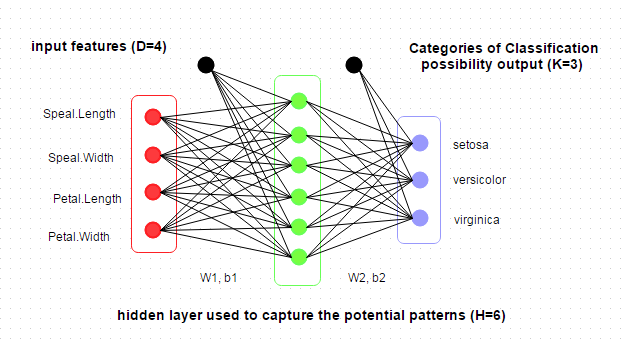



In [47]:
# defining the model 
class MinimalExampleModel(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(MinimalExampleModel, self).__init__()
        # define a first linear layer with an input dimension (D_in) and a Hidden dimension (H)
        # linear layer documentation: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear
        self.linear1 = torch.nn.Linear(D_in, H, bias=True)
        # define the final linear layer, often named classification layer as the output dimension (D_out) == the number of target classes
        self.linear2 = torch.nn.Linear(H, D_out, bias=True)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        # first apply the linear1 layer on the vector and encapsulate it with an activation function for non linearization. This creates a dense layer.
        # relu documentation: https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU 
        h_relu = torch.relu(self.linear1(x))
        y_pred = self.linear2(h_relu)
        return y_pred

### <font color="chillipepper">2. Forward pass</font> 
1. instanciating the model
2. getting input data 
3. computing the foward pass

In [48]:
# instanciating the model with
# N:      batch size
# D_in:   input dimension
# H:      hidden dimension
# D_out:  output dimension
N, D_in, H, D_out = 2, 10, 10, 2

# Construct our model by instantiating the class defined above 
# Note: all the parameters are initialized here 
model = MinimalExampleModel(D_in, H, D_out)
# You can look up into the model 
model

MinimalExampleModel(
  (linear1): Linear(in_features=10, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=2, bias=True)
)

In [49]:
# let's use torchinfo to have a better insight of the model infos: https://github.com/TylerYep/torchinfo
from torchinfo import summary
dummy_input_size = (1, 10) # (batch_size, D_in)
summary(model, (N, D_in))

Layer (type:depth-idx)                   Output Shape              Param #
MinimalExampleModel                      [2, 2]                    --
├─Linear: 1-1                            [2, 10]                   110
├─Linear: 1-2                            [2, 2]                    22
Total params: 132
Trainable params: 132
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [50]:
# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

In [51]:
if torch.cuda.is_available():
  device = 'cuda'
  print('DEVICE = ', colored(torch.cuda.get_device_name(0), "green" ) )
else:
  device = 'cpu'
  print('DEVICE = ', colored('CPU', "blue"))
model = model.to(device)

#model = MyModel(D_in, H, D_out)
# forward pass / predict x 
y_pred = model(x.to(device)) # almost equivalent to model.forward(x)
# y_pred
y_pred

DEVICE =  CPU


tensor([[ 0.1424, -0.0699],
        [ 0.3231,  0.1564]], grad_fn=<AddmmBackward0>)

#### 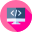 **TODO! Think about it** 
### <font color="chillipepper">Questions</font> 
- Why do the prediction change if the model is re-instanciated ? 
- Can this be a problem ? 
- How to avoid it ? 

#### 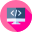 **TODO! Create the model to classify Tweets**

Now let's adapt this model for our classification task!

**Complete the following class** (read the comments!)

In [52]:
class TweetModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, pretrained_vectors=None):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(TweetModel, self).__init__()
        # apply the pretrained embeddings to transform our token indices, into vectors
        self.ebd = torch.nn.Embedding.from_pretrained(pretrained_vectors, freeze=True)
        self.hidden_linear_layer = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.classification_layer = torch.nn.Linear(hidden_dim, output_dim, bias=True)
        # softmax layer to compute class probabilities
        # https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html?highlight=softmax#torch.nn.Softmax
        self.softmax = nn.Softmax(dim=1)

        # define the dropout strategy (here, 20% (0.2) of the vector is ignored to prevent overfitting)
        # we don't use it here but it's a good thing to keep in mind
        # self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        # apply the pretrained embeddings
        x  = self.ebd(x)
        x  = x.mean(1)
        h  = torch.relu(self.hidden_linear_layer( x ))
        # h  = self.dropout(h)
        h  = self.classification_layer(h)
        logits = self.softmax(h)
        return logits

Let's define some variables, considering our data representation.

In [53]:
sizes = next(iter(train_loader))['text'].size()
batchsize = sizes[0]
inputdim  = sizes[1]
print(batchsize, inputdim)

64 200


In [54]:
hiddendim = 300 # dimension of the pretrained vector
outputdim = 3 # because there is 3 classes, i.e. 3 emojis
# we instanciate the model
tweet_model = TweetModel(inputdim, hiddendim, outputdim, pretrained_vectors=pretrained_vectors.vectors)

In [55]:
# we can look at the model 
tweet_model

TweetModel(
  (ebd): Embedding(2519370, 300)
  (hidden_linear_layer): Linear(in_features=300, out_features=300, bias=True)
  (classification_layer): Linear(in_features=300, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

In [56]:
if torch.cuda.is_available():
  device = 'cuda'
  print('DEVICE = ', colored(torch.cuda.get_device_name(0), "green" ) )
else:
  device = 'cpu'
  print('DEVICE = ', colored('CPU', "blue"))
tweet_model.to(device)

DEVICE =  CPU


TweetModel(
  (ebd): Embedding(2519370, 300)
  (hidden_linear_layer): Linear(in_features=300, out_features=300, bias=True)
  (classification_layer): Linear(in_features=300, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

Check if the model is on the GPU (cuda) or CPU

In [57]:
next(tweet_model.parameters()).is_cuda

False

In [58]:
from torchinfo import summary
# to prevent some bugs, move the model to CPU, then move it back to cuda (using the device variable)
# with verbose set to 2 we have more information. however a bug makes it print twice...
print(summary(tweet_model.to('cpu'), (batchsize, inputdim), dtypes=['torch.IntTensor'], device='cpu', verbose=2))
tweet_model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
TweetModel                               [64, 3]                   --
├─Embedding: 1-1                         [64, 200, 300]            (755,811,000)
│    └─weight                                                      └─755,811,000
├─Linear: 1-2                            [64, 300]                 90,300
│    └─weight                                                      ├─90,000
│    └─bias                                                        └─300
├─Linear: 1-3                            [64, 3]                   903
│    └─weight                                                      ├─900
│    └─bias                                                        └─3
├─Softmax: 1-4                           [64, 3]                   --
Total params: 755,902,203
Trainable params: 91,203
Non-trainable params: 755,811,000
Total mult-adds (G): 48.38
Input size (MB): 0.05
Forward/backward pass size (MB): 30.88
Params size 

TweetModel(
  (ebd): Embedding(2519370, 300)
  (hidden_linear_layer): Linear(in_features=300, out_features=300, bias=True)
  (classification_layer): Linear(in_features=300, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

## <font color="chillipepper">Training Loop as a function (to incorporate validation)</font> 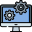

### <font color="chillipepper">3. Training loop </font>

- Criterion : 

a model is trained with regard to a _training criterion_ or a _loss_.   
Pytorch provides many different pre-coded losses : 
    - Mean-Square Error 
    - Categorical Cross-Entropy , ...

Most of them can be found in [torch.nn](https://pytorch.org/docs/stable/nn.html) 
- Optimizer 

In pytorch as in any deep learning framework (Tensorflow for instance), models are trained with backpropagation. Backpropagation consists in applying Stochastic Gradient Descent (SGD) to a neural network. There is a broad range of variants around the simple form of SGD. 

Pytorch provides pre-defined objects for many different forms of Gradient Descent algorithm in [torch.optim](https://pytorch.org/docs/stable/optim.html):
- SGD 
- Adadelta 
- Adam 

In this notebook we use the latter, due to its usually faster convergence.

Your optimizer will be instanciated with it's configuration (*e.g.* the *step_size* or *learning_rate* for SGD), and the network's parameters.

Overview of all the Gradient Descent based algorithms : https://ruder.io/optimizing-gradient-descent/ 


- Training Loop :
    - forward pass to get prediction and the loss value (what a coincidence we have a `forward()` function in our model! 🙂)
    - zero_grad : Resetting the gradient value to zero for all parameters before adding their newly backpropagated values (this step is crucial!) 
    - compute the gradients' value with `loss.backward()`
    - update all the parameters of the model with `optimizer.step()`

The order of these steps should **NOT** be changed!



In [59]:
def train(model, optimizer, ep, args):
  # set the model into a training mode : the model's weights and parameters WILL BE updated!
  model.train()
  # initialize empty lists for losses and accuracies
  loss_it, acc_it = list(), list()

  # start the loop over all the training batches. This means one full epoch.
  for it, batch in tqdm(enumerate(train_loader), desc="Epoch %s:" % (ep), total=train_loader.__len__()):
    
    batch = {'text': batch['text'].to(device), 'label': batch['label'].to(device)}

    # put parameters of the model and the optimizer to zero before doing another iteration. this prevents the gradient accumulation through batches
    optimizer.zero_grad()

    # apply the model on the batch
    logits = model(batch['text'])

    # # # to deal with unbalanced data in the batch, we calculate the weights according to their inverse frequency
    b_counter = Counter(batch['label'].detach().cpu().tolist())
    b_weights = torch.tensor( [ sum(batch['label'].detach().cpu().tolist()) / b_counter[label] if b_counter[label] > 0 else 0 for label in list(range(args['num_class'])) ] )
    b_weights = b_weights.to(device)

    # we choose the CrossEntropyLoss, suitable for multiclass classification
    # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss
    loss_function = nn.CrossEntropyLoss(weight=b_weights)
    # loss_function = nn.CrossEntropyLoss()
    loss = loss_function(logits, batch['label'])

    # compute backpropagation
    loss.backward()

    # indicate to the optimizer we've done a step
    optimizer.step()

    # append the value of the loss for the current iteration (it). .item() retrieve the nuclear value as a int/long
    loss_it.append(loss.item())

    # get the predicted tags using the maximum probability from the softmax
    _, tag_seq  = torch.max(logits, 1)
    
    # Those 3 lines compute the accuracy and then append it the same way as the loss above
    correct = (tag_seq.flatten() == batch['label'].flatten()).float().sum()
    acc = correct / batch['label'].flatten().size(0)
    acc_it.append(acc.item())

  # simple averages of losses and accuracies for this epoch
  loss_it_avg = sum(loss_it)/len(loss_it)
  acc_it_avg = sum(acc_it)/len(acc_it)
  
  # print useful information about the training progress and scores on this training set's full pass (i.e. 1 epoch)
  print("Epoch %s/%s : %s : (%s %s) (%s %s)" % (colored(str(ep), 'blue'),args['max_eps'] , colored('Training', 'blue'), colored('loss', 'cyan'), sum(loss_it)/len(loss_it), colored('acc', 'cyan'), sum(acc_it) / len(acc_it)))


## <font color="chillipepper">Inference Loop as a function</font> 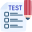

In [60]:
def inference(target, loader, model):
  """
    Args:
      target (str): modify the display, usually either 'validation' or 'test'
  """

  # set the model into a evaluation mode : the model's weights and parameters will NOT be updated!
  model.eval()

  # intialize empty list to populate later on
  loss_it, acc_it, f1_it = list(), list(), list()
  # preds = predicted values ; trues = true values .... obviously~
  preds, trues = list(), list()

  # loop over the loader batches
  for it, batch in tqdm(enumerate(loader), desc="%s:" % (target), total=loader.__len__()):
    # set an environnement without any gradient. So the tensor gradients are not considered 
    # (saves a lot of computation and memory, this is one of the many things that makes predicting far less costly than training)
    with torch.no_grad():

      # put the batch to the correct device
      batch = {'text': batch['text'].to(device), 'label': batch['label'].to(device)}

      # apply the model
      logits = model(batch['text'])

      # # to deal with unbalanced data in the batch, we calculate the weights according to their inverse frequency
      # b_counter = Counter(batch['label'].detach().cpu().tolist())
      # b_weights = torch.tensor( [ sum(batch['label'].detach().cpu().tolist()) / b_counter[label] if b_counter[label] > 0 else 0 for label in list(range(20)) ] )
      # b_weights = b_weights.to(device)

      # loss_function = nn.CrossEntropyLoss(weight=b_weights)
      loss_function = nn.CrossEntropyLoss()
      loss = loss_function(logits, batch['label'])

      # no need to backward() and other training stuff. Directly store the loss in the list
      loss_it.append(loss.item())

      # get the predicted tags using the maximum probability from the softmax
      _, tag_seq  = torch.max(logits, 1)
      
      # compute the accuracy and store it
      correct = (tag_seq.flatten() == batch['label'].flatten()).float().sum()
      acc = correct / batch['label'].flatten().size(0)
      acc_it.append(acc.item())
      
      # extend the predictions and true labels lists so we can compare them later on
      # note how we first ensure the tensor are on cpu (.cpu()), then we detach() the gradient from the tensor, before transforming it to a simple python list (.tolist())
      preds.extend(tag_seq.cpu().detach().tolist())
      trues.extend(batch['label'].cpu().detach().tolist())

  # compute the average loss and accuracy accross the iterations (batches)
  loss_it_avg = sum(loss_it)/len(loss_it)
  acc_it_avg = sum(acc_it)/len(acc_it)
  
  # print useful information. Important during training as we want to know the performance over the validation set after each epoch
  print("%s : (%s %s) (%s %s)" % ( colored(target, 'blue'), colored('loss', 'cyan'), sum(loss_it)/len(loss_it), colored('acc', 'cyan'), sum(acc_it) / len(acc_it)))

  # return the true and predicted values with the losses and accuracies
  return trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it

## <font color="chillipepper">Start Training 📉</font>

In [61]:
import torch.optim as optim

def run_epochs(model, args):

  args['device'] =device
  # if args['cuda'] != -1:
  #     model.cuda(args['cuda'])
  #     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  #     args['device'] = device
  #     print("device set to %s" % (device) )

  # we set the optimizer as Adam with the learning rate (lr) set in the arguments
  # you can look at the different optimizer available here: https://pytorch.org/docs/stable/optim.html
  optimizer = optim.Adam(model.parameters(), lr = args['lr'])

  # define an empty list to store validation losses for each epoch
  val_ep_losses = list()
  # iterate over the number of max epochs set in the arguments
  for ep in range(args['max_eps']):
    # train the model using our defined function
    train(model, optimizer, ep, args)
    # apply the model for inference using our defined function
    trues, preds, val_loss_it_avg, val_acc_it_avg, val_loss_it, val_acc_it = inference("validation", val_loader, model)
    # append the validation losses (good losses should normally go down)
    val_ep_losses.append(val_loss_it_avg)

  # return the list of epoch validation losses in order to use it later to create a plot
  return val_ep_losses
    

In [62]:
# here you can specify if you want a GPU or a CPU by setting the cuda argument as -1 for CPU and another index for GPU. If you only have one GPU, put 0.
args.update({'max_eps': 10, 'lr': 0.001, 'device': 'cpu', 'cuda': 0, 'num_class': 3})
# 1e-05
print('device', device)
# Instantiate model with pre-trained glove vectors
# model = TweetModel(pretrained_embeddings, args['num_class'], args, dimension=50, freeze_embeddings = True )
tweet_model = TweetModel(inputdim, hiddendim, outputdim, pretrained_vectors=pretrained_vectors.vectors)
loss_list_val = run_epochs(tweet_model, args)

device cpu


Epoch 0::   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 0/10 : Training : (loss 1.0958027237064236) (acc 0.3551682692307692)


validation::   0%|          | 0/20 [00:00<?, ?it/s]

validation : (loss 1.1012233316898346) (acc 0.2921875)


Epoch 1::   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 1/10 : Training : (loss 1.0886372170605503) (acc 0.35963255494505497)


validation::   0%|          | 0/20 [00:00<?, ?it/s]

validation : (loss 1.0761293470859528) (acc 0.44609375)


Epoch 2::   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 2/10 : Training : (loss 1.0838749690370246) (acc 0.3716517857142857)


validation::   0%|          | 0/20 [00:00<?, ?it/s]

validation : (loss 1.0831644475460052) (acc 0.353125)


Epoch 3::   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 3/10 : Training : (loss 1.0780009712491716) (acc 0.38255494505494503)


validation::   0%|          | 0/20 [00:00<?, ?it/s]

validation : (loss 1.073007482290268) (acc 0.39453125)


Epoch 4::   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 4/10 : Training : (loss 1.0723764221746843) (acc 0.39139766483516486)


validation::   0%|          | 0/20 [00:00<?, ?it/s]

validation : (loss 1.0658324122428895) (acc 0.41328125)


Epoch 5::   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 5/10 : Training : (loss 1.0688732986921792) (acc 0.4101133241758242)


validation::   0%|          | 0/20 [00:00<?, ?it/s]

validation : (loss 1.0665710747241974) (acc 0.40859375)


Epoch 6::   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 6/10 : Training : (loss 1.065380795971378) (acc 0.41225961538461536)


validation::   0%|          | 0/20 [00:00<?, ?it/s]

validation : (loss 1.0725165545940398) (acc 0.38984375)


Epoch 7::   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 7/10 : Training : (loss 1.0625152869538947) (acc 0.4190418956043956)


validation::   0%|          | 0/20 [00:00<?, ?it/s]

validation : (loss 1.059986597299576) (acc 0.421875)


Epoch 8::   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 8/10 : Training : (loss 1.06270844071776) (acc 0.42058722527472525)


validation::   0%|          | 0/20 [00:00<?, ?it/s]

validation : (loss 1.0556706368923188) (acc 0.428125)


Epoch 9::   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 9/10 : Training : (loss 1.0591495796874328) (acc 0.41603708791208793)


validation::   0%|          | 0/20 [00:00<?, ?it/s]

validation : (loss 1.0555533289909362) (acc 0.46328125)


Now let's plot the validation loss.

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_loss(loss_list):
  '''
  this function creates a plot. a simple curve showing the different values at each steps.
  Here we use it to plot the loss so we named it plot_loss, but the same function with different titles could be used to plot accuracies
  or other metrics for instance.
  
  Args:
    loss_list (list of floats): list of numerical values
  '''
  plt.plot(range(len(loss_list)), loss_list)
  plt.xlabel('epochs')
  # in our model we use Softmax then NLLLoss which means Cross Entropy loss
  plt.ylabel('Cross Entropy')
  # in our training loop we used an Adam optimizer so we indicate it there
  plt.title('lr: {}, optim_alg:{}'.format(args['lr'], 'Adam'))
  # let's directly show the plot when calling this function
  plt.show()

#### 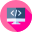 **TODO! Plot the validation loss**

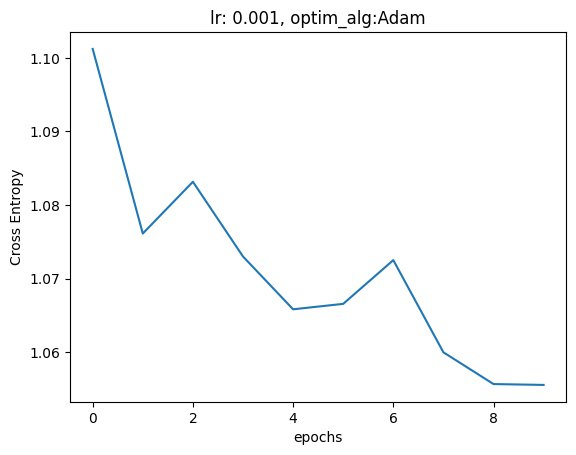

In [64]:
# let's call our function using the list of validation losses to show the plot
plot_loss(loss_list_val)

## <font color="chillipepper">Evaluate the Model 📊</font>

#### 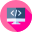 **TODO! use the inference function to apply the model on the test set**

In [65]:
# let's use our model for inference on the test set. We can short it by naming it "test our model"
# we set the target as "test" to print the correct info, and use the test loader
trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it = inference("test", test_loader, tweet_model)

test::   0%|          | 0/187 [00:00<?, ?it/s]

test : (loss 1.0692922817194526) (acc 0.43373997326203206)


It may be quite huge but let's compare the real values and the predicted ones side by side

In [66]:
# let's look at the first ten predictions
for t, p in zip(trues[:10], preds[:10]):
  correct = colored('Correct', 'green') if t == p else colored('Mistake', 'red')
  print('true', t, 'predicted', p, correct)

true 1 predicted 1 Correct
true 2 predicted 2 Correct
true 1 predicted 0 Mistake
true 1 predicted 0 Mistake
true 1 predicted 0 Mistake
true 1 predicted 1 Correct
true 1 predicted 0 Mistake
true 0 predicted 2 Mistake
true 1 predicted 2 Mistake
true 0 predicted 0 Correct


Let's print the classification report to have an idea of each class performance and the macro average f1 score

In [67]:
# the full emojis in case you want to consider all of them (you would need to change the previous cells)
# names = ["❤", "😍", "😂", "💕", "🔥", "😊", "😎","✨", "💙", "😘", "📷", "🇺🇸", "☀", "💜", "😉", "💯", "😁", "🎄", "📸", "😜"]
names = ["😍", "😂", "💕"]

#### 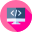 **TODO! Plot the classification report**

You may need to specify the target_names.

link: 
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

In [72]:
! pip install scikit-plot

In [75]:
from scikitplot.metrics import plot_roc_curve
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten(), target_names=names))

              precision    recall  f1-score   support

           😍       0.45      0.57      0.50      4830
           😂       0.58      0.29      0.39      4533
           💕       0.31      0.42      0.36      2605

    accuracy                           0.43     11968
   macro avg       0.45      0.43      0.42     11968
weighted avg       0.47      0.43      0.43     11968



#### 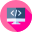 **TODO! Plot the confusion matrix**

Let's print the confusion matrix. This is the core part to dive into model's performance indications.

You need to **complete the following code**.

Link:
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix

/Users/pcolombo/anaconda3/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 128525 (\N{SMILING FACE WITH HEART-SHAPED EYES}) missing from current font.
  fig.canvas.draw()
/Users/pcolombo/anaconda3/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 128514 (\N{FACE WITH TEARS OF JOY}) missing from current font.
  fig.canvas.draw()
/Users/pcolombo/anaconda3/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 128149 (\N{TWO HEARTS}) missing from current font.
  fig.canvas.draw()
/Users/pcolombo/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128525 (\N{SMILING FACE WITH HEART-SHAPED EYES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/pcolombo/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128514 (\N{FACE WITH TEARS OF JOY}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/pcolombo/anaconda3/lib/

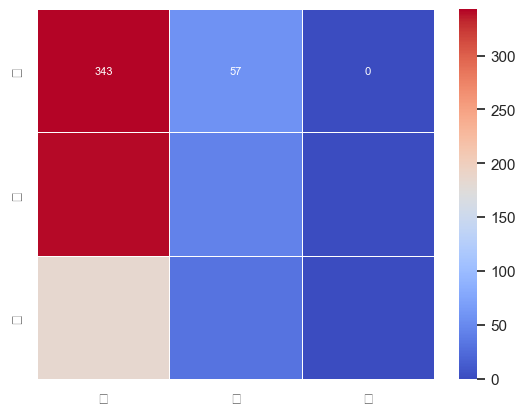

In [92]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sn
import matplotlib
matplotlib.rcParams.update({'font.family': ('cmr10', 'STIXGeneral')})
plt.rcParams["font.serif"] = "cmr10"
cm = confusion_matrix(np.array(trues).flatten(), np.array(preds).flatten())
df_cm = pd.DataFrame(cm, index=names, columns=names)
# config plot sizes
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.show()

#### 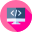 **TODO! Insights 🤔 and experiments**

Try to change the learning rate, the optimizers, or the classes.

What can you say about the results?

In [80]:
# optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=0.9)#, weight_decay=0.001)
# optimizer = optim.Adagrad(model.parameters(), lr=args['lr'])

## <font color="chillipepper">What about BERT?</font>

You can find a tutorial on finetuning here : https://huggingface.co/docs/transformers/training

And look at the following code cells which modify the model you used to exploit BERT pretrained vectors and finetune them.

We consider `bert-tiny`to have a very small version of BERT (so the finetuning is faster), this renders the results less viable. To finetune the real `bert-base-cased` with all the training samples would take a lot of time.

In [81]:
tweet_eval = load_dataset('tweet_eval', 'emoji')
def adjust_labels(entries):
  res = {}
  res['text'] = entries['text']
  res['label'] = [ label - 1 for label in entries['label']]
  return res

for split in ['train', 'validation', 'test']:
  rows_to_select = [ i for i, entry in enumerate(tweet_eval[split]) if entry['label'] <= 3 and entry['label'] != 0 ]
  tweet_eval[split] = tweet_eval[split].select(rows_to_select)
  tweet_eval[split] = tweet_eval[split].map(lambda e: adjust_labels(e)  , batched=True)

In [82]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", use_fast=True)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = tweet_eval.map(tokenize_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/11657 [00:00<?, ? examples/s]

Map:   0%|          | 0/11969 [00:00<?, ? examples/s]

Map:   0%|          | 0/1333 [00:00<?, ? examples/s]

In [83]:
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

In [84]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(200))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

In [85]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=8)

In [86]:
from transformers import AutoModelForSequenceClassification
# This model is equal to BERT + a linear layer for classification. In our custom model we designed a FastText + a hidden layer and linear layer for classification
model = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=3)

config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [87]:
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=5e-5)

In [88]:
from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [89]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/75 [00:00<?, ?it/s]

In [90]:
from datasets import load_metric
metric = load_metric("accuracy")
model.eval()
preds, trues = [], []
for i, batch in tqdm(enumerate(eval_dataloader), desc="evaluating", total=eval_dataloader.__len__()):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

    _, tag_seq  = torch.max(logits, 1)
    preds.extend(tag_seq.cpu().detach().tolist())
    trues.extend(batch['labels'].cpu().detach().tolist())

metric.compute()

/var/folders/m3/h_276b0j01x2tp0btl5lw2s40000gr/T/ipykernel_77767/3472972976.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

{'accuracy': 0.387}

In [93]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten(), target_names=names))

              precision    recall  f1-score   support

           😍       0.40      0.86      0.54       400
           😂       0.33      0.11      0.17       385
           💕       0.00      0.00      0.00       215

    accuracy                           0.39      1000
   macro avg       0.24      0.32      0.24      1000
weighted avg       0.29      0.39      0.28      1000



/Users/pcolombo/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pcolombo/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pcolombo/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/Users/pcolombo/anaconda3/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 128525 (\N{SMILING FACE WITH HEART-SHAPED EYES}) missing from current font.
  fig.canvas.draw()
/Users/pcolombo/anaconda3/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 128514 (\N{FACE WITH TEARS OF JOY}) missing from current font.
  fig.canvas.draw()
/Users/pcolombo/anaconda3/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 128149 (\N{TWO HEARTS}) missing from current font.
  fig.canvas.draw()
/Users/pcolombo/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128525 (\N{SMILING FACE WITH HEART-SHAPED EYES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/pcolombo/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128514 (\N{FACE WITH TEARS OF JOY}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/pcolombo/anaconda3/lib/

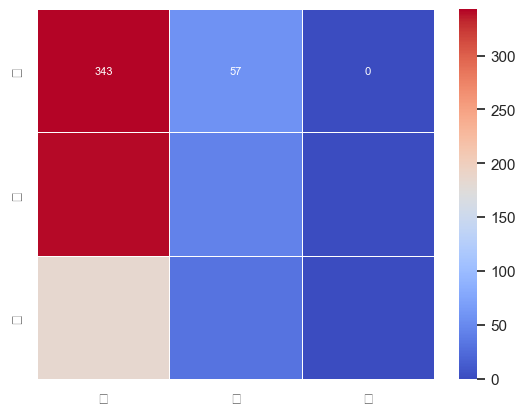

In [95]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sn

cm = confusion_matrix(np.array(trues).flatten(), np.array(preds).flatten())
df_cm = pd.DataFrame(cm, index=names, columns=names)
# config plot sizes
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.show()

# <font color="chillipepper">**Sequence Classification with Conversational Context** </font>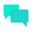 -> 💬 -> `__dummy__`, `inform`, `question`, `directive`, `commissive`

For this task we will use a dataset made of dialogs. This adds a new level to the classification task, each message being a part of a sequence (the conversation).

In this lab, we only consider the dialog acts. Here is the dialog acts indice mapping:
`__dummy__` (0), `inform` (1), `question` (2), `directive` (3), `commissive` (4).

```
This example was too long and was cropped:
{
    "act": [2, 1, 1, 1, 1, 2, 3, 2, 3, 4],
    "dialog": "[\"Good afternoon . This is Michelle Li speaking , calling on behalf of IBA . Is Mr Meng available at all ? \", \" This is Mr Meng ..."
}
```


| name  |train|validation|test|
|-------|----:|---------:|---:|
|default|11118|      1000|1000|

Links:
- https://huggingface.co/datasets/daily_dialog

Once again we consider the data handling.

In [96]:
dailydialog = load_dataset('daily_dialog')

Generating train split:   0%|          | 0/11118 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [97]:
dailydialog

DatasetDict({
    train: Dataset({
        features: ['dialog', 'act', 'emotion'],
        num_rows: 11118
    })
    validation: Dataset({
        features: ['dialog', 'act', 'emotion'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['dialog', 'act', 'emotion'],
        num_rows: 1000
    })
})

In [98]:
entry = dailydialog['train'][0]
entry

{'dialog': ['Say , Jim , how about going for a few beers after dinner ? ',
  ' You know that is tempting but is really not good for our fitness . ',
  ' What do you mean ? It will help us to relax . ',
  " Do you really think so ? I don't . It will just make us fat and act silly . Remember last time ? ",
  " I guess you are right.But what shall we do ? I don't feel like sitting at home . ",
  ' I suggest a walk over to the gym where we can play singsong and meet some of our friends . ',
  " That's a good idea . I hear Mary and Sally often go there to play pingpong.Perhaps we can make a foursome with them . ",
  ' Sounds great to me ! If they are willing , we could ask them to go dancing with us.That is excellent exercise and fun , too . ',
  " Good.Let ' s go now . ",
  ' All right . '],
 'act': [3, 4, 2, 2, 2, 3, 4, 1, 3, 4],
 'emotion': [0, 0, 0, 0, 0, 0, 4, 4, 4, 4]}

## <font color="chillipepper">Data Handling</font>

#### 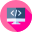 **TODO! Adapt the data handling**

Complete the following code by taking into account the hierarchical level:
- conversation
  - message -> act

In [99]:
from nltk.tokenize import TweetTokenizer
from tqdm.notebook import tqdm
import numpy as np

tok = TweetTokenizer()

def tokenize_pad_numericalize_dialog(entry, vocab_stoi, max_length=20):
  ''' message level '''
  dialog = [ [ vocab_stoi[token] if token in vocab_stoi else vocab_stoi['<unk>'] for token in tok.tokenize(e.lower()) ] 
          for e in entry ]
  padded_dialog = list()
  for d in dialog:
    if len(d) < max_length:    padded_dialog.append( d + [ vocab_stoi['<pad>'] for i in range(len(d), max_length) ] )
    elif len(d) > max_length:  padded_dialog.append(d[:max_length])
    else:                      padded_dialog.append(d) 
  return padded_dialog

def tokenize_all_dialog(entries, vocab_stoi, max_message_length=20, max_dialog_length=12):
  ''' dialog level '''
  pad_message = [ vocab_stoi['<pad>'] ]
  pad_label = [0] # because 0 means dummy in dialog acts mapping
  res_dialog, res_labels = [], []

  for entry in entries['dialog']:
    text  = tokenize_pad_numericalize_dialog(entry, vocab_stoi)
    if len(text) < max_dialog_length:    text = text + [ [vocab_stoi['<pad>']] * max_message_length for i in range(len(text), max_dialog_length)]   # pad_message * (max_dialog_length - len(text))
    elif len(text) > max_dialog_length:  text = text[-max_dialog_length:] # keeps the last n messages
    res_dialog.append(text)

  for labels in entries['act']:
    if len(labels) < max_dialog_length:   labels = labels + [ 0 for i in range(len(labels), max_dialog_length) ]          # pad_label * (max_dialog_length - len(labels))
    elif len(labels) > max_dialog_length: labels = labels[-max_dialog_length:]
    res_labels.append(labels)

  res = {'text': res_dialog, 'label': res_labels}
  return res

vocab_stoi = pretrained_vocab.get_stoi()

for split in ['train', 'validation', 'test']:
  dailydialog[split] = dailydialog[split].map(lambda e: tokenize_all_dialog(e, vocab_stoi), batched=True)

Map:   0%|          | 0/11118 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [100]:
dailydialog

DatasetDict({
    train: Dataset({
        features: ['dialog', 'act', 'emotion', 'text', 'label'],
        num_rows: 11118
    })
    validation: Dataset({
        features: ['dialog', 'act', 'emotion', 'text', 'label'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['dialog', 'act', 'emotion', 'text', 'label'],
        num_rows: 1000
    })
})

The dataset class is the same. But we could put the data handling in the Dataset class. To keep it simple, we separate both processes.

In [101]:
from torch.utils.data import Dataset
import numpy as np

class DialogActDataset(Dataset):
    def __init__(self, data, args):
      self.args = args
      self.data = data

    def __len__(self):
      return len(self.data)
    
    def __getitem__(self, idx):
      item = {
          "text": np.array(self.data[idx]['text']),
          "label": np.array(self.data[idx]['label'])
      }
      return item

In [103]:
from torch.utils.data import DataLoader
args = {'bsize': 64}
train_loader = DataLoader(DialogActDataset(dailydialog['train'], args), batch_size=args['bsize'], num_workers=0, shuffle=True, drop_last=True)
val_loader   = DataLoader(DialogActDataset(dailydialog['validation'], args), batch_size=args['bsize'], num_workers=0, shuffle=True, drop_last=True)
test_loader  = DataLoader(DialogActDataset(dailydialog['test'], args), batch_size=args['bsize'], num_workers=0, shuffle=True, drop_last=True)

In [104]:
next(iter(train_loader))['text'].shape

torch.Size([64, 12, 20])

## <font color="chillipepper">Create the Model dedicated to conversations</font>

First, please find here a custom layer which will only compute the average of the embeddings for a message. You will need it later on and it serves to show how to integrate custom models, inside a model.

In [105]:
import torch.nn as nn
class SimpleAvgConvEBD(nn.Module):
    '''
        An aggregation method that encodes every document by its average word
        embeddings.
    '''
    def __init__(self, ebd, args, avg_global=False):
        super(SimpleAvgConvEBD, self).__init__()

        # self.ebd = ebd
        self.ebd = torch.nn.Embedding.from_pretrained(pretrained_vectors.vectors, freeze=True)

        self.avg_global = avg_global


    def forward(self, data):
        '''
            @param data dictionary
                @key text: batch_size * max_text_len
            @return output: batch_size * embedding_dim
        '''
        ebd = self.ebd(data)

        # count length excluding <pad> and <unk>.
        is_zero = (torch.sum(torch.abs(ebd), dim=3) > 1e-8).float() 
        soft_len = torch.sum(is_zero, dim=2, keepdim=True)

        soft_len[soft_len < 1] = 1

        # # don't need to mask out the <pad> tokens, as the embeddings are zero
        ebd = torch.sum(ebd, dim=2) # dim = 2
        ebd = ebd / soft_len

        # avg_global allows two usages for this model
        if self.avg_global:
            ebd = torch.mean(ebd, 2)
        return ebd

#### 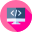 **TODO! Adapt the model**

**Complete the following code** to adapt the model to consider the two levels and the conversational context with biddirectional LSTMs.

Please look into the model and se the differences, here we actually compute the loss in the forward pass. It is up to your preference to do so.

Docs:
- https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM
- https://pytorch.org/docs/stable/nn.html

In [106]:
import torch
# this import contains multiple CLASSES to use (hence you need to instanciate it). Usually different layer types
import torch.nn as nn
# this import contains multiple FUNCTIONS to use (hence no need to instanciate it)
import torch.nn.functional as F


# create the class by inheriting the PyTorch Module
class BiLSTM(nn.Module):

    def __init__(self, pretrained_embeddings, num_class, args, dimension=300, freeze_embeddings = False):
        '''
        construtor of the class (function automatically used when creating a new instance of this class)
        '''
        super(BiLSTM, self).__init__()

        # put args as a class variable
        self.args = args
        # create the embedding layer from the pretrained vectors
        self.embedding = nn.Embedding.from_pretrained(pretrained_vectors.vectors, freeze=freeze_embeddings)

        # instanciate the SimpleAvgConvEBD class, dedicate to average the utterances
        self.utterance_ebd = SimpleAvgConvEBD(None, {}, avg_global=False)
        # put the SimpleAvgConvEBD instance into the device (cpu or gpu), depending on the arguments
        if self.args['cuda'] != -1: self.utterance_ebd.cuda(args['cuda'])

        # put dimension as a class variable
        self.dimension = dimension

        # instanciate the LSTM class from PyTorch. Dimensions are divided by 2 due to bidirectional being True
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension//2, 
                            num_layers=3,
                            batch_first=True,
                            bidirectional=True)
        # instanciate a dropout layer with 0.5. This means, we will ignore (put to zeros) half (0.5) of the data to prevent the model from overfitting
        self.drop = nn.Dropout(p=0.5)

        # instanciate a linear layer with an output size equal to the number of classes. This means this will be used to apply a criterion to compute the predictions.
        self.hidden2tag = nn.Linear(dimension, num_class)

    def forward(self, data, text_len=12):
        '''
        The forward function. Used to apply the model (during training or inference).
        '''
        # # use the function previously defined, in order to put the data values in the GPU is said so in the args
        # data = batch_to_cuda(data, self.args['cuda'])
        # # keep the device in a variable in order to prevent further mistakes
        # device = data['text'].device

        # use the utterance average embeddings to transform the data['text'] into a representation of conversation with a vector per utterance 
        text_emb = self.utterance_ebd(data['text'])

        # apply the LSTM and retrieve the output, and the hidden vector. Hidden vector is not used afterwards. It would be useful in case of another type of LSTM for instance
        output, hidden = self.lstm(text_emb)

        # apply the dropout layer (ignore 50% of the data)
        output = self.drop(output)

        # apply the linear layer to have class logits
        outputs = self.hidden2tag(output)

        # keep some dimension infos as variable for convenience
        batch_size = outputs.size(0)
        seq_len = outputs.size(1)

        # modify the outputs representation to prepare score computation
        outputs = outputs.view(batch_size*seq_len, -1)
        # apply a softmax on the outputs to obtain probabilities
        scores = F.log_softmax(outputs, 1)

        # get the predicted tags using the maximum probability from the softmax
        _, tag_seq  = torch.max(scores, 1)
        # reshape the predicted tags to follow the batch and sequence length
        tag_seq = tag_seq.view(batch_size, seq_len)

        # some example of manual class weights
        # weights = torch.Tensor([0.1, 1, 1, 1, 1, 1, 1]).to(device)

        
        if 'class_weights' in self.args:
          # class weights from args if there is any. It should be a torch tensor, but we move it to the dedicated device
          # we use class weights to influence the Negative Log Likelihood. Influencing in the same time the backpropagation and, thus, the update of the model
          loss_fn = nn.NLLLoss(weight=self.args['class_weights'].to(device))  
        else: 
          # if not 'class_weights' key in the args dict(), we use the Negative Log Likelihood as is
          loss_fn = nn.NLLLoss()

        # apply the loss function (Softmax + NLLLoss = Cross Entropy)
        loss = loss_fn(scores, data['label'].view(batch_size*seq_len))

        # we return 3 elements as a tuple : the loss, the softmax outputs, and the predicted tag set already in a good format
        return loss, scores, tag_seq

In [107]:
def train(model, optimizer, ep, args):
  # set the model into a training mode : the model's weights and parameters WILL BE updated!
  model.train()
  # initialize empty lists for losses and accuracies
  loss_it, acc_it = list(), list()

  # start the loop over all the training batches. This means one full epoch.
  for it, batch in tqdm(enumerate(train_loader), desc="Epoch %s:" % (ep), total=train_loader.__len__()):
    
    # put parameters of the model and the optimizer to zero before doing another iteration
    optimizer.zero_grad()
    model.zero_grad()

    # apply the model on the batch
    loss, logits, tag_seq = model(batch)
    # compute gradient values
    loss.backward()
    # indicate to the optimizer we've done a step
    optimizer.step()
    # append the value of the loss for the current iteration (it). .item() retrieve the nuclear value as a int/long
    loss_it.append(loss.item())
    
    # Those 3 lines compute the accuracy and then append it the same way as the loss above
    correct = (tag_seq.flatten() == batch['label'].flatten()).float().sum()
    acc = correct / batch['label'].flatten().size(0)
    acc_it.append(acc.item())

  # simple averages of losses and accuracies for this epoch
  loss_it_avg = sum(loss_it)/len(loss_it)
  acc_it_avg = sum(acc_it)/len(acc_it)
  
  # print useful information about the training progress and scores on this training set's full pass (i.e. 1 epoch)
  print("Epoch %s/%s : %s : (%s %s) (%s %s)" % (colored(str(ep), 'blue'),args['max_eps'] , colored('Training', 'blue'), colored('loss', 'cyan'), sum(loss_it)/len(loss_it), colored('acc', 'cyan'), sum(acc_it) / len(acc_it)))


In [108]:
def inference(target, loader, model):
  """
    Args:
      target (str): modify the display, usually either 'validation' or 'test'
  """
  # set the model into a evaluation mode : the model's weights and parameters will NOT be updated!
  model.eval()

  # intialize empty list to populate later on
  loss_it, acc_it, f1_it = list(), list(), list()
  # preds = predicted values ; trues = true values .... obviously~
  preds, trues = list(), list()

  # loop over the loader batches
  for it, batch in tqdm(enumerate(loader), desc="%s:" % (target), total=loader.__len__()):
    # set an environnement without any gradient. So the tensor gradients are not considered 
    # (saves a lot of computation and memory, this is one of the many things that makes predicting far less costly than training)
    with torch.no_grad():
      # apply the model
      loss, logits, tag_seq = model(batch)
      # no need to backward() and other training stuff. Directly store the loss in the list
      loss_it.append(loss.item())
      
      # compute the accuracy and store it
      correct = (tag_seq.flatten() == batch['label'].flatten()).float().sum()
      acc = correct / batch['label'].flatten().size(0)
      acc_it.append(acc.item())
      
      # extend the predictions and true labels lists so we can compare them later on
      # note how we first ensure the tensor are on cpu (.cpu()), then we detach() the gradient from the tensor, before transforming it to a simple python list (.tolist())
      preds.extend(tag_seq.cpu().detach().tolist())
      trues.extend(batch['label'].cpu().detach().tolist())

  # compute the average loss and accuracy accross the iterations (batches)
  loss_it_avg = sum(loss_it)/len(loss_it)
  acc_it_avg = sum(acc_it)/len(acc_it)
  
  # print useful information. Important during training as we want to know the performance over the validation set after each epoch
  print("%s : (%s %s) (%s %s)" % ( colored(target, 'blue'), colored('loss', 'cyan'), sum(loss_it)/len(loss_it), colored('acc', 'cyan'), sum(acc_it) / len(acc_it)))

  # return the true and predicted values with the losses and accuracies
  return trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it

## <font color="chillipepper">Start Training 📉</font>

In [109]:
import torch.optim as optim

def run_epochs(model, args):

  if args['cuda'] != -1:
      model.cuda(args['cuda'])
      device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      args['device'] = device
      print("device set to %s" % (device) )

  # we set the optimizer as Adam with the learning rate (lr) set in the arguments
  # you can look at the different optimizer available here: https://pytorch.org/docs/stable/optim.html
  optimizer = optim.Adam(model.parameters(), lr = args['lr'])

  # define an empty list to store validation losses for each epoch
  val_ep_losses = list()
  # iterate over the number of max epochs set in the arguments
  for ep in range(args['max_eps']):
    # train the model using our defined function
    train(model, optimizer, ep, args)
    # apply the model for inference using our defined function
    trues, preds, val_loss_it_avg, val_acc_it_avg, val_loss_it, val_acc_it = inference("validation", val_loader, model)
    # append the validation losses (good losses should normally go down)
    val_ep_losses.append(val_loss_it_avg)

  # return the list of epoch validation losses in order to use it later to create a plot
  return val_ep_losses
    

In [ ]:
# here you can specify if you want a GPU or a CPU by setting the cuda argument as -1 for CPU and another index for GPU. If you only have one GPU, put 0.
args.update({'max_eps': 10, 'lr': 0.001, 'device': 'cpu', 'cuda': -1, 'seq_len':12, 'num_class': 5})

# Instantiate model with pre-trained fasttext vectors
# Here we set the dimension to 50 to make it faster and we only consider a small conversation length (12)
model = BiLSTM(pretrained_vectors.vectors, args['num_class'], args, dimension=50, freeze_embeddings = True )
loss_list_val = run_epochs(model, args)

Epoch 0::   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 0/10 : Training : (loss 0.9413457984869191) (acc 0.6071923175299099)


validation::   0%|          | 0/15 [00:00<?, ?it/s]

validation : (loss 0.8397444486618042) (acc 0.6219618082046509)


Epoch 1::   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 1/10 : Training : (loss 0.7615616428369731) (acc 0.6671935223430567)


validation::   0%|          | 0/15 [00:00<?, ?it/s]

validation : (loss 0.8130833546320597) (acc 0.6256076335906983)


Epoch 2::   0%|          | 0/173 [00:00<?, ?it/s]

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_loss(loss_list):
  '''
  this function creates a plot. a simple curve showing the different values at each steps.
  Here we use it to plot the loss so we named it plot_loss, but the same function with different titles could be used to plot accuracies
  or other metrics for instance.
  
  Args:
    loss_list (list of floats): list of numerical values
  '''
  plt.plot(range(len(loss_list)), loss_list)
  plt.xlabel('epochs')
  # in our model we use Softmax then NLLLoss which means Cross Entropy loss
  plt.ylabel('Cross Entropy')
  # in our training loop we used an Adam optimizer so we indicate it there
  plt.title('lr: {}, optim_alg:{}'.format(args['lr'], 'Adam'))
  # let's directly show the plot when calling this function
  plt.show()

In [ ]:
# let's call our function using the list of validation losses to show the plot
plot_loss(loss_list_val)

## <font color="chillipepper">Evaluate the Model 📊</font>

#### 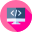 **TODO! Evaluate it**

**Do all the evaluation**: 
- predict on testset
- classification report
- confusion matrix

In [ ]:
# let's use our model for inference on the test set. We can short it by naming it "test our model"
# we set the target as "test" to print the correct info, and use the test loader
trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it = inference("test", test_loader, model)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
names = ['__dummy__', 'inform', 'question', 'directive', 'commissive']
names.remove('__dummy__') # dummy label is not interesting
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten(), target_names=names, labels=[1, 2, 3, 4]))

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sn

cm = confusion_matrix(np.array(trues).flatten(), np.array(preds).flatten())
names = ['__dummy__', 'inform', 'question', 'directive', 'commissive']
df_cm = pd.DataFrame(cm, index=names, columns=names)
# config plot sizes
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.show()

# <font color="chillipepper">**Conclusion**</font>



In this lab you gained ✔️:
- [x] The most common PyTorch basics
- [x] A classification task using static pretrained embbedings and a very simple model
- [x] A sequence classification considering the conversational context, using average representation and bidirectional recurrent networks
- [x] How to handle different types of data for each task
- [x] How to deal with training, validation and test sets
- [x] How to incorporate a pretrained BERT in a classification task